<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

from scipy.stats import bernoulli, beta  

import sys

import bayes 

In [2]:
# datos
cats = pd.read_csv('./data/cookie_cats.csv')
cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
cats.shape

(90189, 5)

In [4]:
cats.userid.unique().shape # Tenemos el mismo número de id's que de filas así que no hay usuarios repetidos. Check.

(90189,)

In [5]:
cats.version.value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

## AB Testing - Frecuentista

* Vamos a hacer el test en primer lugar por el método frecuentista - 1 sample vs 1 sample

* H0: mu = 0
* H1: mu != 0 -> two-sided test


In [6]:
from scipy.stats import ttest_ind 

In [7]:
# transformacion
control = cats[cats.version == 'gate_30']
tratamiento = cats[cats.version == 'gate_40']

print(f'Control tiene {control.shape[0]} filas y Tratamiento tiene {tratamiento.shape[0]} filas')


Control tiene 44700 filas y Tratamiento tiene 45489 filas


In [8]:
control.retention_1.value_counts()

retention_1
False    24666
True     20034
Name: count, dtype: int64

In [9]:
control.retention_7.value_counts()

retention_7
False    36198
True      8502
Name: count, dtype: int64

In [10]:
tratamiento.retention_1.value_counts()

retention_1
False    25370
True     20119
Name: count, dtype: int64

In [11]:
tratamiento.retention_7.value_counts()

retention_7
False    37210
True      8279
Name: count, dtype: int64

In [12]:
ttest_ind(control.retention_1, tratamiento.retention_1)

TtestResult(statistic=1.7840979256519656, pvalue=0.07441111525563184, df=90187.0)

* Obteniendo un pvalor > 0.05 no podemos rechazar la H0 -> no hay una diferencia entre los gate_30 y los gate_40 para la retención 

In [13]:
ttest_ind(control.retention_7, tratamiento.retention_7)

TtestResult(statistic=3.1644994996802778, pvalue=0.0015540151201088365, df=90187.0)

* Obteniendo un pvalor < 0.05 podemos rechazar la H0 y decir que sí que hay una diferencia entre aquellos users a los que el juego paró en la puerta 30 frente a aquellos a los que el juego paró en la puerta 40. Los jugadores a los que se paró en la puerta 40 tienen mayor probabilidad de estar activos en el día 7 después de haber descargado el juego.

## AB Testing - Bayesiano

* Vamos a hacer el test por el método Bayesiano

In [14]:
pd.crosstab(cats.version, cats.retention_1)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [15]:
pd.crosstab(cats.version, cats.retention_7)

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


### Retention_1

In [16]:
# Retention_1

imps_ctrl, convs_ctrl = 44700, 20034    # gate_30 -> True + False, True

imps_test, convs_test = 45489, 20119   # gate_40 -> True + False, True


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.4481879194630872, Test: 0.44228274967574577'

In [17]:
# muestreo
# a prioris

a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl # todo - aciertos

a_T, b_T = 1+convs_test, 1+imps_test-convs_test # todo - aciertos


beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [18]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

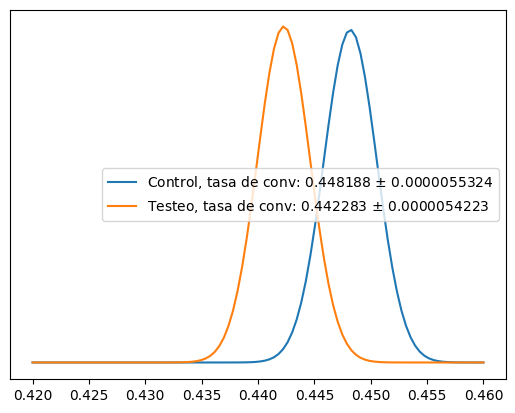

In [35]:
bayes.plot([beta_control, beta_test], ['Control', 'Testeo'])

In [36]:
prob1 = bayes.calc_prob(beta_control, beta_test)
prob1

0.9627939748515354

In [37]:
salto1 = (beta_test.mean() - beta_control.mean())/beta_control.mean() # Media(test) - Media(control) / media(control) para normalizar

salto1

-0.013175098158249857

In [54]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto1*100, prob1*100)

'El test aumenta la tasa de conversion en un -1.32%, con una probabilidad del 96.28%'

In [56]:
# Que el test aumente en un valor negativo quiere decir que disminuye :)

# Osea que el test es peor que el control.

### Retention_7

In [20]:
# testeo para retention_7
imps_ctrl, convs_ctrl = 44700, 8502    # gate_30 -> True + False, True

imps_test, convs_test = 45489, 8279   # gate_40 -> True + False, True


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'


'Tasas conversion: Control: 0.19020134228187918, Test: 0.18200004396667327'

In [45]:
#help(beta)

In [21]:
# muestreo
# a prioris

a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl # todo - aciertos

a_T, b_T = 1+convs_test, 1+imps_test-convs_test # todo - aciertos


beta_control7 = beta(a_C, b_C)

beta_test7 = beta(a_T, b_T)

In [22]:
beta_control7.mean(), beta_test7.mean()

(0.19021520289919913, 0.18201402475214878)

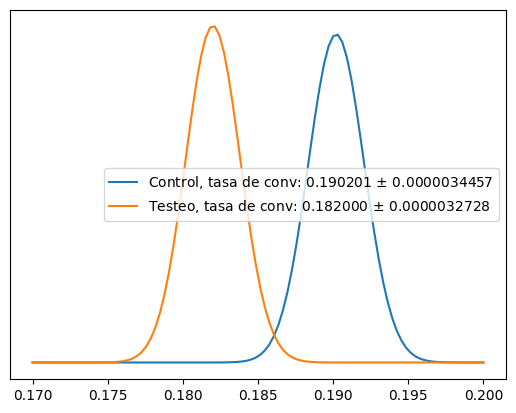

In [27]:
bayes.plot([beta_control7, beta_test7], ['Control', 'Testeo'], linf=0.17, lsup=0.20)

In [39]:
prob7 = bayes.calc_prob(beta_control7, beta_test7)
prob7

0.9992226613235504

In [40]:
salto7 = (beta_test7.mean() - beta_control7.mean())/beta_control7.mean() # Media(test) - Media(control) / media(control) para normalizar

salto7

-0.04311526114658881

In [57]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto7*100, prob7*100)

'El test aumenta la tasa de conversion en un -4.31%, con una probabilidad del 99.92%'

In [ ]:
# Una vez más, un aumento de un valor negativo es una disminución. Esto quiere decir que el test es peor que el control.

# Es curioso que nos salgan conclusiones diferentes utilizando el método frecuentista y Bayesiano...